In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Change Directory
import os
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data') # Laptop @ J: # Desktop @ J:
print('-----------------------------------------------------')
print('WD: ', os.getcwd())
print('-----------------------------------------------------')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("default") 
%matplotlib inline
from matplotlib import ticker
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator, DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
years  =  mdates.YearLocator()
months =  mdates.MonthLocator()
days   =  mdates.DayLocator()
hours  =  mdates.HourLocator()
month_name = DateFormatter("%b")
day_name = DateFormatter('%d')

#file_path = ('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\df_concat_1H_PYCO2SYS.csv')
file_path = ('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\df_concat_1H_clean.csv')
df_concat_1H = pd.read_csv(file_path, parse_dates=[0], index_col=[0])

# Change Units of Barometric Pressure  (mbar to dbar)
df_concat_1H['p_dbar_w'] = df_concat_1H['p_rad'] * (0.01)
# Average Air Temperature 
df_concat_1H['t_air_w'] = (df_concat_1H['t_air'] + df_concat_1H['t_rad'])/2
# Change Units of Barometric Pressure  (mbar to atm)
df_concat_1H['p_rad_atm'] = df_concat_1H['p_rad'] / (1013.25)
# Change Units of Barometric Pressure  (mbar to dbar)
df_concat_1H['p_dbar_w'] = df_concat_1H['p_rad'] * (0.01)

df_concat_1H['iH2CO3'] = df_concat_1H['ico2_w'] + df_concat_1H['ε_CO2_H2CO3']
df_concat_1H['iHCO3'] = df_concat_1H['ico2_w'] + df_concat_1H['ε_CO2_HCO3']
df_concat_1H['iCO3'] = df_concat_1H['ico2_w'] + df_concat_1H['ε_CO2_CO3']

# Air T = t_air
# Water T = t_adcp

-----------------------------------------------------
WD:  J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data
-----------------------------------------------------


#### Notes
> Converted barometric pressure from mbar to atm for this calculation.

> Only the pH, Water Temperature, and Water Pressure were used in this prediction. 

> opt_k_carbonic = 8: M79 (0 < T < 50 °C, S = 0, freshwater only).

> No Data for 'alkalinity', 'dic', 'bicarbonate', 'carbonate',

In [2]:
file_path = ('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\PYCO2SYS_Results_df_concat_1H.csv')
df_results = pd.read_csv(file_path)

df_results = df_results[['par1',
                         'aqueous_CO2',  # umol/kg
                         'pCO2', # uatm
                         'fCO2', # uatm
                         'xCO2', # ppm
                         'k_CO2', # Henry's Constant [atm·kg/mol]
                         'k_carbonic_1', # H2CO3 = HCO3
                         'k_carbonic_2', # HCO3 = CO3
                         'gas_constant', # ideal gas constant  (1/mbar·mol·K)
                        ]]

In [3]:
# Determined via PYCO2SYS (pco2, T_w, P_a)
df_concat_1H['CO2_aq'] = df_results['aqueous_CO2'].values
df_concat_1H['pCO2_w_uatm'] = (df_results['pCO2'].values)
df_concat_1H['k_CO2'] = df_results['k_CO2'].values
df_concat_1H['k_1'] = df_results['k_carbonic_1'].values
df_concat_1H['k_2'] = df_results['k_carbonic_2'].values

# Convert pCO2_a from [ppm] to [atm]
df_concat_1H['pCO2_a_uatm'] = df_concat_1H['co2_a'] * df_concat_1H['p_rad_atm']

# Flux (atm)
df_concat_1H['ΔpCO2_atm'] = (df_concat_1H['pCO2_w_uatm'] - df_concat_1H['pCO2_a_uatm'])*(10**-6)

### CO2 Gas Solubility Coefficients (Weiss 1974 @ Eq. 12)
<br>
$$ Sc  =  Α + B\cdot{T} + C\cdot{T}^2 + D\cdot{T}^3 + E\cdot{T}^4 $$

- T [C]

<br>

### Gas Transfer Coefficient (Wanninkhof 2014)

$$ k_g = 0.251 \cdot U_{\text{mean}}^2 \cdot \left( \frac{Sc}{660} \right)^{-0.5} $$


### CO2 Gas Solubility Coefficients (Weiss 1974 @ Eq. 12)
<br>
$$ ln(k_0)  =  Α_1 + Α_2\cdot(\frac{100}{T}) + A_3\cdot ln(\frac{T}{100}) + S\cdot(B_1 + B_2\cdot(\frac{T}{100}) + B_3\cdot(\frac{T}{100})^2 ) $$

- T [K]
<br>

# Bulk Flux
$$ F  =  k_0 \cdot k_g \cdot (pCO_{2,w} - pCO_{2,a})$$
<br>
- k_0 = [mol/kg•atm]
- k_g = [m/s]
- ΔpCO2 = [ppm] -----> umol/mol ?

In [4]:
############################################################################################
# Schmidt Number @ Sc = A + B*(T) + C*(T**2) + D*(T**3) + E*(T**4)
FW_co2 = [1923.6, -125.06, 4.3773, -0.085681, 0.00070284]
A, B, C, D, E = FW_co2
df_concat_1H['Sc'] = A + B*(df_concat_1H['t_adcp']) + C*(df_concat_1H['t_adcp']**2) + D*(df_concat_1H['t_adcp']**3) + E*(df_concat_1H['t_adcp']**4)
############################################################################################
# Air–Water gas exchange coefficient (k, [m/s])
# k_g = 0.251 * (u_10**2) * (Sc/660)**(-0.5)
df_concat_1H['k_g'] = 0.251 * (df_concat_1H['u']**2) * (df_concat_1H['Sc']/660)**(-0.5)
############################################################################################
# Solubility (k0, [mol/kg•atm])

# k0 [mol/L*atm]
#A1l, A2l, A3l, B1l, B2l, B3l = -58.0931, 90.5069, 22.2940, 0.027766, -0.025888, 0.0050578

# k0 [mol/kg*atm]
A1, A2, A3, B1, B2, B3 = [-60.2409, 93.4517, 23.3585, 0.023517, 0.023656, 0.0047036]
S=0

# Solubility (k0, [mol/kg•atm])
#df_concat_1H['ln_k0'] = A1 + A2*( 100 / (df_concat_1H['t_adcp'] + 273.15) ) + A3*np.log( (df_concat_1H['t_adcp'] + 273.15) / 100) + S*(B1 + B2*( (df_concat_1H['t_adcp'] + 273.15) / 100) + B3*( (df_concat_1H['t_adcp'] + 273.15) / 100)**2))
#df_concat_1H['k0'] = np.exp(df_concat_1H['ln_k0'])
df_concat_1H['k_0'] = np.exp(A1 + A2*( 100 / (df_concat_1H['t_adcp'] + 273.15) ) + A3*np.log( (df_concat_1H['t_adcp'] + 273.15) / 100) + S*(B1 + B2*( (df_concat_1H['t_adcp'] + 273.15) / 100) + B3*( (df_concat_1H['t_adcp'] + 273.15) / 100)**2))
############################################################################################
# Flux [mol/m2·s] = k_0 [mol/kg] * k_g [m/s] * [atm] * [kg/m3]
FW_density = 999.82 #[kg/m3]
df_concat_1H['Flux_pCO2'] = df_concat_1H['k_0']*df_concat_1H['k_g']*df_concat_1H['ΔpCO2_atm']*FW_density
############################################################################################
# Flux from [mol/m2·s] to [kg/m2·s]
MW_co2 = 44.01 # [g/mol]
df_concat_1H['Flux_CO2_kg'] = df_concat_1H['Flux_pCO2'] * MW_co2 * (10**-3)
############################################################################################
# Flux from [mol/m2·s] to [kg/m2·s]
MW_c = 12.011 # [g/mol]
df_concat_1H['Flux_C_kg'] = df_concat_1H['Flux_pCO2'] * MW_c * (10**-3)
############################################################################################
df_concat_1H['Flux_CO2_kg_hr'] = df_concat_1H['Flux_CO2_kg'] * 3600
df_concat_1H['Flux_C_kg_hr'] = df_concat_1H['Flux_C_kg'] * 3600
############################################################################################

<AxesSubplot:xlabel='date_time'>

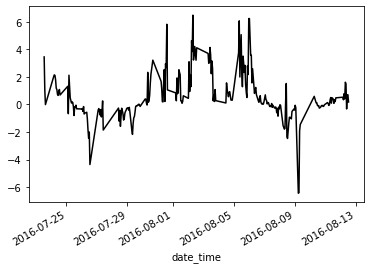

In [5]:
df_concat_1H['Flux_C_kg_hr'].plot(c='black')

<AxesSubplot:xlabel='date_time'>

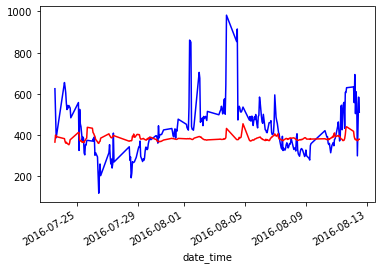

In [6]:
df_concat_1H['pCO2_w_uatm'].plot(c='b')
df_concat_1H['pCO2_a_uatm'].plot(c='r')

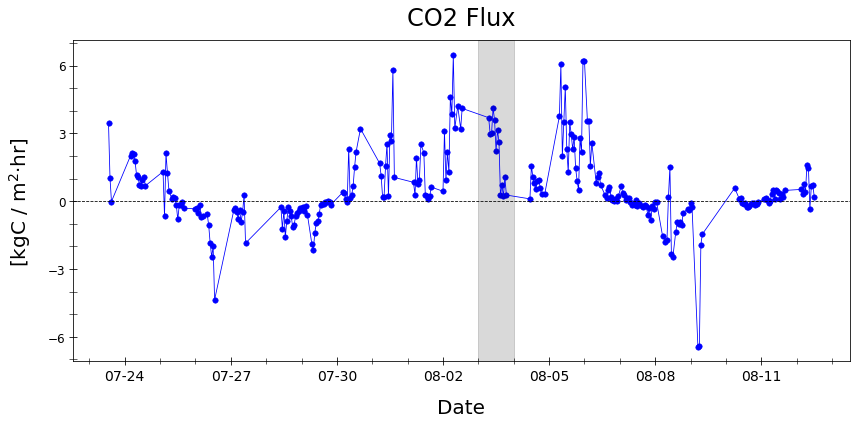

In [7]:
# Plot
fig, ax = plt.subplots(figsize=(12,6), )
ax.set_title('CO2 Flux', color='black', fontsize=24, pad=15)
ax.set_ylabel('[kgC / m$^2$·hr]', color='black', fontsize=20, labelpad=15)
ax.set_xlabel('Date', color='black', fontsize=20, labelpad=15)

ax.plot(df_concat_1H.index, df_concat_1H['Flux_C_kg_hr'], c = 'blue', lw=0.8)  # pCO$_{2,water}$
ax.scatter(df_concat_1H.index, df_concat_1H['Flux_C_kg_hr'], c = 'blue', lw=0.5, s=30)  

#ax[0].set_ylim([50, 1200])
#ax[1].set_ylim([-30, 0])
#ax.legend(fontsize=16, loc='upper left') # bbox_to_anchor=(1.0, 1.00)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout', length=6)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=12, color='black')
ax.yaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=6, color='black')
ax.yaxis.set_major_locator(MaxNLocator(5)) 
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(3))
#ax.grid(axis='x',c='black',ls='--',lw='1',alpha=0.8)
ax.axvspan(datetime.date(2016,8,3), datetime.date(2016,8,4), alpha=0.15, color='black')
ax.axhline(0, c='black', lw=0.8, ls='--')
fig.tight_layout()

#fig.savefig('Flux_co2_1.png', dpi = 500, bbox_inches='tight')

In [8]:
# Transect I
df_concat_1H_1 = df_concat_1H.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 
df_concat_1H_2 = df_concat_1H.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']

# Sort
df_concat_1H_1 = df_concat_1H_1.sort_values(by='lat', ascending=True)
df_concat_1H_2 = df_concat_1H_2.sort_values(by='lat', ascending=True)

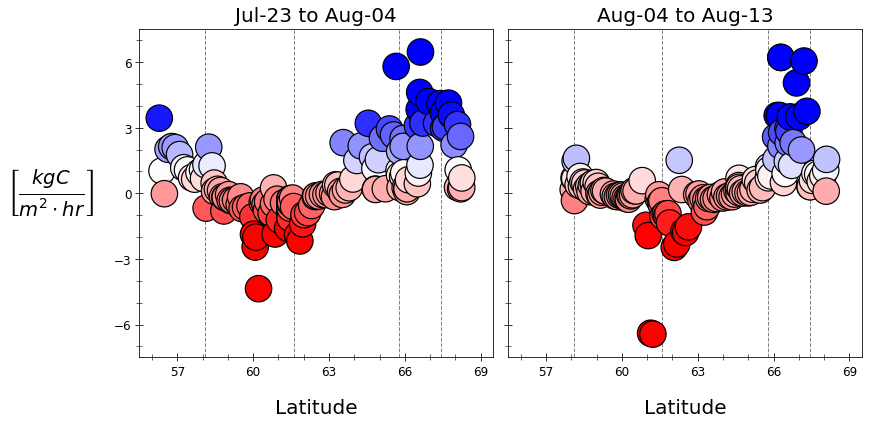

In [9]:
# Water
def flux_co2(x1, y1, data1, data2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    
    ax[0].set_title('Jul-23 to Aug-04', fontsize=20, c='black', pad=8)
    ax[1].set_title('Aug-04 to Aug-13', fontsize=20, c='black', pad=8)
    ax[0].set_ylabel(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', color='black', 
                     fontsize=28, rotation=0) # labelpad=50, 
    ax[0].get_yaxis().set_label_coords(-0.25, 0.425)
    ax[0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
    ax[1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
    
    ax[0].scatter(data1[x1], data1[y1], cmap='bwr_r', lw=1.2, edgecolor='black', s=700, zorder=1, 
                  c=data1[y1],  vmin=data1[y1].quantile(0.05), vmax=data1[y1].quantile(0.95))
    
    ax[1].scatter(data2[x1], data2[y1], cmap='bwr_r', lw=1.2, edgecolor='black', s=700, zorder=1, 
                  c=data2[y1], vmin=data2[y1].quantile(0.05), vmax=data2[y1].quantile(0.95))   
    
    for ax in ax:
        ax.set_xlim(55.5, 69.5)
        #ax.set_ylim(-150, 350)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))              
        ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
        ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
        ax.yaxis.set_major_locator(MaxNLocator(5)) 
        ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(3))
        ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
        ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
        ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
        ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
        ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
        ax.axvline(67.44, color='grey', ls='--', lw=1, zorder=0)  # Igarka
        ax.set_ylim(-7.5,7.5)
        #ax.axvspan(61, 62, alpha=0.15, color='black')

    #fig.suptitle('J$_{CO2}$', fontsize=40, x=0.535, y=0.92)
    fig.tight_layout()
        
    return fig, ax

fig, ax = flux_co2('lat', 'Flux_C_kg_hr', df_concat_1H_1, df_concat_1H_2)

fig.savefig('Flux_CO2_cruisies_1H.png', dpi = 500, bbox_inches='tight')

<AxesSubplot:xlabel='date_time'>

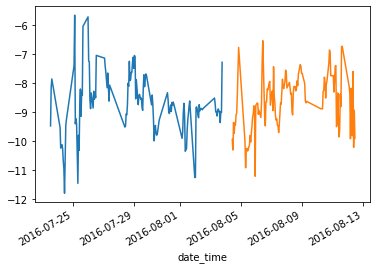

In [10]:
df_concat_1H_1['J_ico2'].plot()
df_concat_1H_2['J_ico2'].plot()

Text(0, 0.5, '13CO2_w')

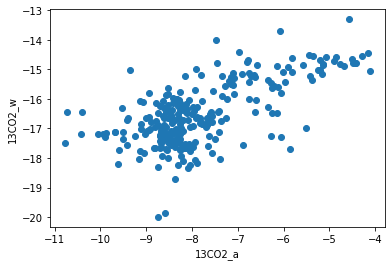

In [11]:
#df_concat_1H['ico2_w'].plot(c='b')
#df_concat_1H['ico2_a'].plot(c='r')

plt.scatter(df_concat_1H['ico2_a'],df_concat_1H['ico2_w'])
plt.xlabel('13CO2_a')
plt.ylabel('13CO2_w')

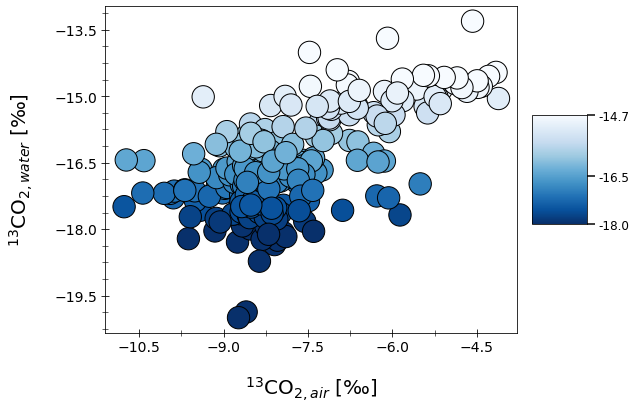

In [12]:
fig, ax = plt.subplots(figsize=(9,6))

#ax.set_title('Water Samples (Raw Data)', fontsize=24, c='black', pad=15)
ax.set_xlabel('$^{13}$CO$_{2,air}$ [‰]', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CO$_{2,water}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = df_concat_1H['ico2_w'].quantile(0.05)
vmax = df_concat_1H['ico2_w'].quantile(0.95)
mean_value = df_concat_1H['ico2_w'].mean()

mappable = ax.scatter(df_concat_1H['ico2_a'], df_concat_1H['ico2_w'], cmap = 'Blues_r', c = df_concat_1H['ico2_w'], 
                      edgecolor= 'black', lw=1.0, s=500, zorder=1,
                      vmin=vmin, vmax=vmax)

#ax.axvline(1200, color='black', ls='--',lw=1.2)
#ax.axhline(-22, color='black', ls='--', lw=1.2)
#ax.axhline(-10, color='black', ls='--', lw=1.2)
#ax.axvline(1300, color='black', ls='--', lw=1.2)

#ax.set_xlim(-1,32)
#ax.set_ylim(-24,-4)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(4))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CO$_{2}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

###fig.savefig('Raw_Yenisei_2016_co2_ico2_water.png', dpi = 500, bbox_inches='tight')

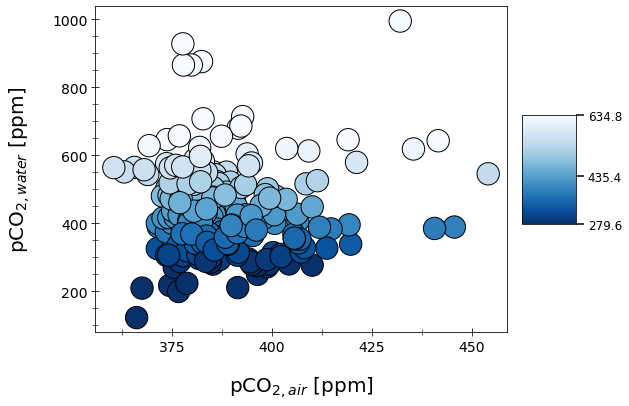

In [13]:
fig, ax = plt.subplots(figsize=(9,6))

#ax.set_title('Water Samples (Raw Data)', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCO$_{2,air}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('pCO$_{2,water}$ [ppm]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = df_concat_1H['co2_w'].quantile(0.05)
vmax = df_concat_1H['co2_w'].quantile(0.95)
mean_value = df_concat_1H['co2_w'].mean()

mappable = ax.scatter(df_concat_1H['co2_a'], df_concat_1H['co2_w'], cmap = 'Blues_r', c = df_concat_1H['co2_w'], 
                      edgecolor= 'black', lw=1.0, s=500, zorder=1,
                      vmin=vmin, vmax=vmax)

#ax.axvline(1200, color='black', ls='--',lw=1.2)
#ax.axhline(-22, color='black', ls='--', lw=1.2)
#ax.axhline(-10, color='black', ls='--', lw=1.2)
#ax.axvline(1300, color='black', ls='--', lw=1.2)

#ax.set_xlim(-1,32)
#ax.set_ylim(-24,-4)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(4))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CO$_{2}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

###fig.savefig('Raw_Yenisei_2016_co2_co2_water.png', dpi = 500, bbox_inches='tight')

<AxesSubplot:xlabel='date_time'>

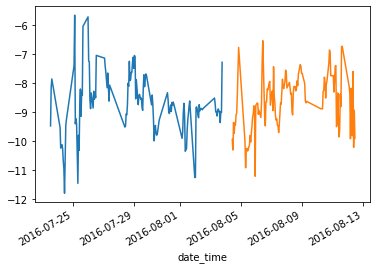

In [14]:
df_concat_1H_1['J_ico2'].plot()
df_concat_1H_2['J_ico2'].plot()

In [15]:
df_concat_1H.columns

Index(['ch4_w', 'ich4_w', 'co2_w', 'ico2_w', 'year', 'month', 'day', 'hour',
       'ε_CO2_H2CO3', 'iH2CO3', 'ε_CO2_HCO3', 'iHCO3', 'ε_CO2_CO3', 'iCO3',
       'ch4_a', 'ich4_a', 'co2_a', 'ico2_a', 'lon_a', 'year.1', 'month.1',
       'day.1', 'hour.1', 'lat', 'lon', 'u', 'u_dir', 'swr', 'lwr', 'rh',
       't_air', 't_dew', 't_adcp', 't_rad', 'p_rad', 'sog', 'cog', 'J_co2',
       'J_ico2', 'J_ch4', 'J_ich4', 'dT', 'p_dbar_w', 't_air_w', 'p_rad_atm',
       'CO2_aq', 'pCO2_w_uatm', 'k_CO2', 'k_1', 'k_2', 'pCO2_a_uatm',
       'ΔpCO2_atm', 'Sc', 'k_g', 'k_0', 'Flux_pCO2', 'Flux_CO2_kg',
       'Flux_C_kg', 'Flux_CO2_kg_hr', 'Flux_C_kg_hr'],
      dtype='object')

<AxesSubplot:xlabel='date_time'>

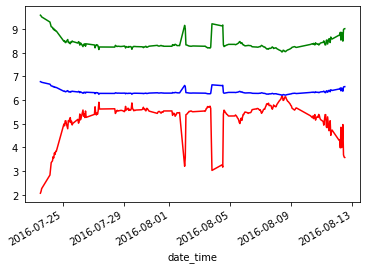

In [16]:
df_concat_1H['ε_CO2_H2CO3'].plot(c='red')
df_concat_1H['ε_CO2_HCO3'].plot(c='green')
df_concat_1H['ε_CO2_CO3'].plot(c='blue')

<AxesSubplot:xlabel='date_time'>

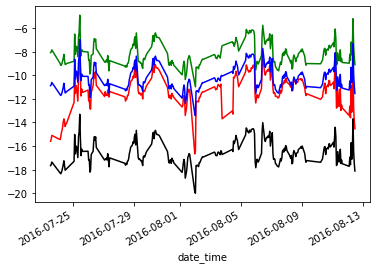

In [17]:
df_concat_1H['iH2CO3'].plot(c='red')
df_concat_1H['iHCO3'].plot(c='green')
df_concat_1H['iCO3'].plot(c='blue')
df_concat_1H['ico2_w'].plot(c='black')

In [18]:
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point, LineString, Polygon, mapping
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.plot import plotting_extent
from rasterio.crs import CRS

# HydroSHEDS Maps
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data')
AGRO_Watershed = gpd.read_file('ArcticGRO_Yenisei_watershed')
gpd_rivers = gpd.read_file('GeoPandas_Yenisei_rivers')
gpd_lakes = gpd.read_file('GeoPandas_Yenisei_lakes')
# Group gdp rivers by name and clip
gpd_rivers_yenisei = gpd_rivers.dissolve(by='name_en', aggfunc='sum')
# Clipping the entire gpd_rivers using the ArcticGRO_Watershed as the mask
gpd_rivers_yenisei = gpd.clip(gpd_rivers_yenisei, AGRO_Watershed)
# Individual Tributaries
Yenisey = gpd_rivers_yenisei.loc[gpd_rivers_yenisei.index == 'Yenisey']
nt = gpd_rivers_yenisei.loc[gpd_rivers_yenisei.index == 'Nizhnyaya Tunguska']
pt = gpd_rivers_yenisei.loc[gpd_rivers_yenisei.index == 'Podkamennaya Tunguska']
Angara = gpd_rivers_yenisei.loc[gpd_rivers_yenisei.index == 'Angara']

#ORD_CLASS
HydroRIVERS_Yenisei_Class_main = gpd.read_file('HydroRIVERS_Yenisei_Class_main')
# ORD_FLOW
HydroRIVERS_flow_2 = HydroRIVERS_Yenisei_Class_main.loc[HydroRIVERS_Yenisei_Class_main['ORD_FLOW'] == 2]
HydroRIVERS_flow_3 = HydroRIVERS_Yenisei_Class_main.loc[HydroRIVERS_Yenisei_Class_main['ORD_FLOW'] == 3]
HydroRIVERS_flow_4 = HydroRIVERS_Yenisei_Class_main.loc[HydroRIVERS_Yenisei_Class_main['ORD_FLOW'] == 4]
HydroRIVERS_flow_5 = HydroRIVERS_Yenisei_Class_main.loc[HydroRIVERS_Yenisei_Class_main['ORD_FLOW'] == 5]
HydroRIVERS_flow_6 = HydroRIVERS_Yenisei_Class_main.loc[HydroRIVERS_Yenisei_Class_main['ORD_FLOW'] == 6]

# Import Siberian Markers (Amon_2016_Yenisei)
markers = 'Siberian_Markers_1.txt'
markers = pd.read_csv(markers, delim_whitespace=True, skiprows=0)
markers.columns = markers.columns.str.strip()
markers.index = markers.Name
Dudinka_marker = markers.loc['Dudinka'] # 
Igarka_marker = markers.loc['Igarka'] # 
N_Tunguska_marker = markers.loc['N_Tunguska'] # 
S_Tuguska_marker = markers.loc['S_Tuguska'] # 
P_Tunguska_marker = markers.loc['P_Tunguska'] # 
Boguchany_marker = markers.loc['Boguchany'] # https://en.wikipedia.org/wiki/Boguchany_Dam
Angara_marker = markers.loc['Angara'] # 
Krasnoyarsk_marker = markers.loc['Krasnoyarsk'] # https://en.wikipedia.org/wiki/Krasnoyarsk
Irkutsk_marker = markers.loc['Irkutsk'] # https://en.wikipedia.org/wiki/Irkutsk
markers = markers.sort_values(by='lat', ascending=False) # https://matplotlib.org/stable/api/markers_api.html

# Raster
nat_earth = rasterio.open("Yenisei_NE1_HR_LC_SR.tif")

# Stacking
def read_bands(raster, band_numbers):
  """Reads the specified bands from a raster and returns an np.array."""
  bands = []
  for band_number in band_numbers:
    band = raster.read(band_number)
    bands.append(band)
  return np.stack(bands, axis=-1)

def gamma_correction(image, gamma):
    """Applies gamma correction to an image."""
    # Normalize the image to 0-1
    normalized_image = image / 255.0
    # Apply gamma correction
    corrected_image = np.power(normalized_image, 1/gamma)
    # Denormalize the image back to 0-255
    return (corrected_image * 255).astype(np.uint8)

# Stacked Raster (np.array)
nat_earth_image = read_bands(nat_earth, [1, 2, 3])

# Apply gamma correction
gamma_value = 0.333
nat_earth_image_gamma_corrected = gamma_correction(nat_earth_image, gamma_value)


def make_background_transparent(image, background_color=np.array([0, 0, 0]), tolerance=10):
    """
    Makes the specified background color of an image transparent.
    
    Parameters:
        - image (np.array): The input image.
        - background_color (np.array): The color to be made transparent.
        - tolerance (int): The tolerance level for color matching.
        
    Returns:
        - np.array: The image with transparent background.
    """
    # Determine the shape of the image dynamically
    height, width, channels = image.shape

    # Add an alpha channel with an initial value of 255 (fully opaque)
    alpha_channel = np.full((height, width, 1), 255, dtype=np.uint8)
    image_with_alpha = np.concatenate((image, alpha_channel), axis=2)

    # Calculate the absolute difference between each pixel and the background color
    color_difference = np.abs(image - background_color)
    # Calculate the maximum color difference across channels
    max_color_difference = np.max(color_difference, axis=2)
    # Create a mask for pixels matching the background color within the tolerance
    background_mask = max_color_difference <= tolerance
    # Set the alpha channel to 0 (fully transparent) for pixels matching the background
    image_with_alpha[background_mask, 3] = 0
    
    return image_with_alpha

# Apply the function to the gamma-corrected image
Yenisei_NE1_HR_LC_SR = make_background_transparent(nat_earth_image_gamma_corrected)

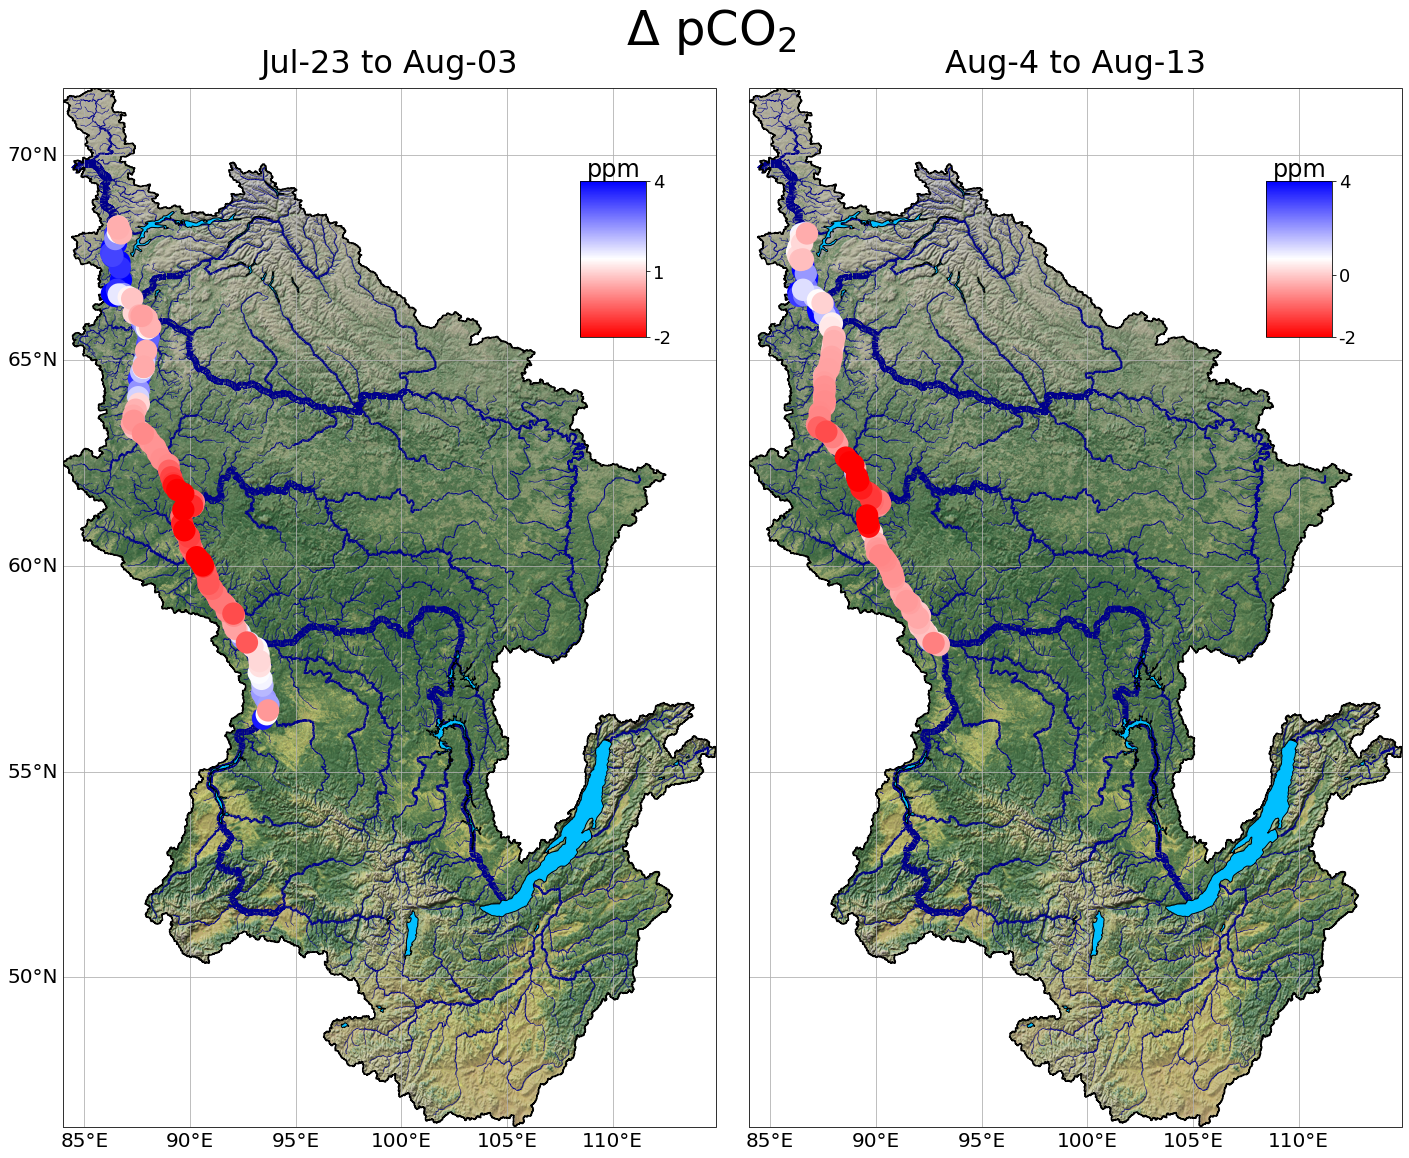

In [19]:
# Sort
df_concat_1H_1 = df_concat_1H_1.sort_values(by='Flux_C_kg_hr', ascending=False)
df_concat_1H_2 = df_concat_1H_2.sort_values(by='Flux_C_kg_hr', ascending=False)

# Plot Structure
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(24,24), subplot_kw={"projection": ccrs.PlateCarree()})

# Titles
ax[0].set_title('Jul-23 to Aug-03', fontsize=32, c='black', pad=15)
ax[1].set_title('Aug-4 to Aug-13', fontsize=32, c='black', pad=15)
# Scatters
m1 = ax[0].scatter(df_concat_1H_1['lon'], df_concat_1H_1['lat'], c=df_concat_1H_1['Flux_C_kg_hr'], cmap='bwr_r', transform = ccrs.PlateCarree(), 
                   vmin=df_concat_1H_1['Flux_C_kg_hr'].quantile(0.05), vmax=df_concat_1H_1['Flux_C_kg_hr'].quantile(0.95), marker='o', s=500, linewidth=1, edgecolor='none', zorder=9)
m2 = ax[1].scatter(df_concat_1H_2['lon'], df_concat_1H_2['lat'], c=df_concat_1H_2['Flux_C_kg_hr'], cmap='bwr_r', transform = ccrs.PlateCarree(), 
                   vmin=df_concat_1H_2['Flux_C_kg_hr'].quantile(0.05), vmax=df_concat_1H_2['Flux_C_kg_hr'].quantile(0.95), marker='o', s=500, linewidth=1, edgecolor='none', zorder=9)
# Grids
gl1 = ax[0].gridlines(draw_labels=True, linewidth=0.8, x_inline=False, y_inline=False, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)
gl1.xlabel_style, gl1.ylabel_style, gl1.top_labels, gl1.right_labels = {'size': 20, 'color': 'black'}, {'size': 20, 'color': 'black'}, False, False
gl2 = ax[1].gridlines(draw_labels=True, linewidth=0.8, x_inline=False, y_inline=False, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)
gl2.xlabel_style, gl2.ylabel_style, gl2.top_labels, gl2.right_labels = {'size': 20, 'color': 'black'}, {'size': 0, 'color': 'white'}, False, False

# Colorbar 1
cb_ax1 = inset_axes(ax[0], width="10%", height="15%", loc='upper right', bbox_to_anchor=(-0.100, -0.085, 1, 1), bbox_transform=ax[0].transAxes)
cb1 = plt.colorbar(m1, cax=cb_ax1)
cb1.set_label(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', fontsize=18, labelpad=100)
cb1.ax.tick_params(labelsize=18)
cb1.set_ticks([df_concat_1H_1['Flux_C_kg_hr'].quantile(0.05), df_concat_1H_1['Flux_C_kg_hr'].mean(), df_concat_1H_1['Flux_C_kg_hr'].quantile(0.95)])
cb1.set_ticklabels(['{:.1f}'.format(df_concat_1H_1['Flux_C_kg_hr'].quantile(0.05)), '{:.1f}'.format(df_concat_1H_1['Flux_C_kg_hr'].mean()), '{:.1f}'.format(df_concat_1H_1['Flux_C_kg_hr'].quantile(0.95))])
cb1.ax.yaxis.set_label_coords(-0.1, 1.2)  # Adjust the x and y coordinates as needed
cb1.ax.set_ylabel(cb1.ax.get_ylabel(), rotation=0, fontsize=24, ha='left', va='center')

# Colorbar 2
cb_ax2 = inset_axes(ax[1], width="10%", height="15%", loc='upper right', bbox_to_anchor=(-0.100, -0.085, 1, 1), bbox_transform=ax[1].transAxes)
cb2 = plt.colorbar(m2, cax=cb_ax2)
cb2.set_label(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', fontsize=18, labelpad=80)
cb2.ax.tick_params(labelsize=18)
cb2.set_ticks([df_concat_1H_2['Flux_C_kg_hr'].quantile(0.05), df_concat_1H_2['Flux_C_kg_hr'].mean(), df_concat_1H_2['Flux_C_kg_hr'].quantile(0.95)])
cb2.set_ticklabels(['{:.1f}'.format(df_concat_1H_2['Flux_C_kg_hr'].quantile(0.05)), '{:.1f}'.format(df_concat_1H_2['Flux_C_kg_hr'].mean()), '{:.1f}'.format(df_concat_1H_2['Flux_C_kg_hr'].quantile(0.95))])
cb2.ax.yaxis.set_label_coords(-0.1, 1.2)  # Adjust the x and y coordinates as needed
cb2.ax.set_ylabel(cb2.ax.get_ylabel(), rotation=0, fontsize=24, ha='left', va='center')

# Loops
for ax in ax:
    xmin, ymin, xmax, ymax = nat_earth.bounds # Get the extent of the raster image
    ax.imshow(Yenisei_NE1_HR_LC_SR, origin='upper', extent=[xmin, xmax, ymin, ymax], transform=ccrs.PlateCarree())
    AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
    gpd_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', lw=1, zorder=6)
    HydroRIVERS_flow_2.plot(ax=ax, color='darkblue', lw=8, zorder=1)
    HydroRIVERS_flow_3.plot(ax=ax, color='darkblue', lw=6, zorder=2)
    HydroRIVERS_flow_4.plot(ax=ax, color='darkblue', lw=2, zorder=3)
    HydroRIVERS_flow_5.plot(ax=ax, color='darkblue', lw=1, zorder=4) # < 10$^2$ [m$^3$/s]
    HydroRIVERS_flow_6.plot(ax=ax, color='darkblue', lw=0.5, zorder=4) # label='10$^0$ - 10$^1$ [m$^3$/s]'
    #ax.legend(ncol=1, prop={'size': 18}) # prop={'size': 24}
        
#fig.tight_layout()

# Add a main title (suptitle)
plt.suptitle('F$_{CO2}$', fontsize=48, x=0.55, y=0.85)

# Adjust padding between subplots manually
plt.subplots_adjust(wspace=0.05)

fig.savefig('Yenisei_2016_FLUX_1H.png', dpi = 500, bbox_inches='tight')

In [32]:
df_concat_1H.columns

Index(['ch4_w', 'ich4_w', 'co2_w', 'ico2_w', 'year', 'month', 'day', 'hour',
       'ε_CO2_H2CO3', 'iH2CO3', 'ε_CO2_HCO3', 'iHCO3', 'ε_CO2_CO3', 'iCO3',
       'ch4_a', 'ich4_a', 'co2_a', 'ico2_a', 'lon_a', 'year.1', 'month.1',
       'day.1', 'hour.1', 'lat', 'lon', 'u', 'u_dir', 'swr', 'lwr', 'rh',
       't_air', 't_dew', 't_adcp', 't_rad', 'p_rad', 'sog', 'cog', 'J_co2',
       'J_ico2', 'J_ch4', 'J_ich4', 'dT', 'p_dbar_w', 't_air_w', 'p_rad_atm',
       'CO2_aq', 'pCO2_w_uatm', 'k_CO2', 'k_1', 'k_2', 'pCO2_a_uatm',
       'ΔpCO2_atm', 'Sc', 'k_g', 'k_0', 'Flux_pCO2', 'Flux_CO2_kg',
       'Flux_C_kg', 'Flux_CO2_kg_hr', 'Flux_C_kg_hr'],
      dtype='object')

In [31]:
# Group the data by each day
group_1 = df_concat_1H.groupby(df_concat_1H.index.date)

In [80]:
# Calculate the number of subplots needed
num_subplots = len(group_1)
# Calculate the number of rows and columns for the subplot grid
num_rows = math.ceil(num_subplots / 3)  # Round up the division result to the nearest integer
num_cols = 3 

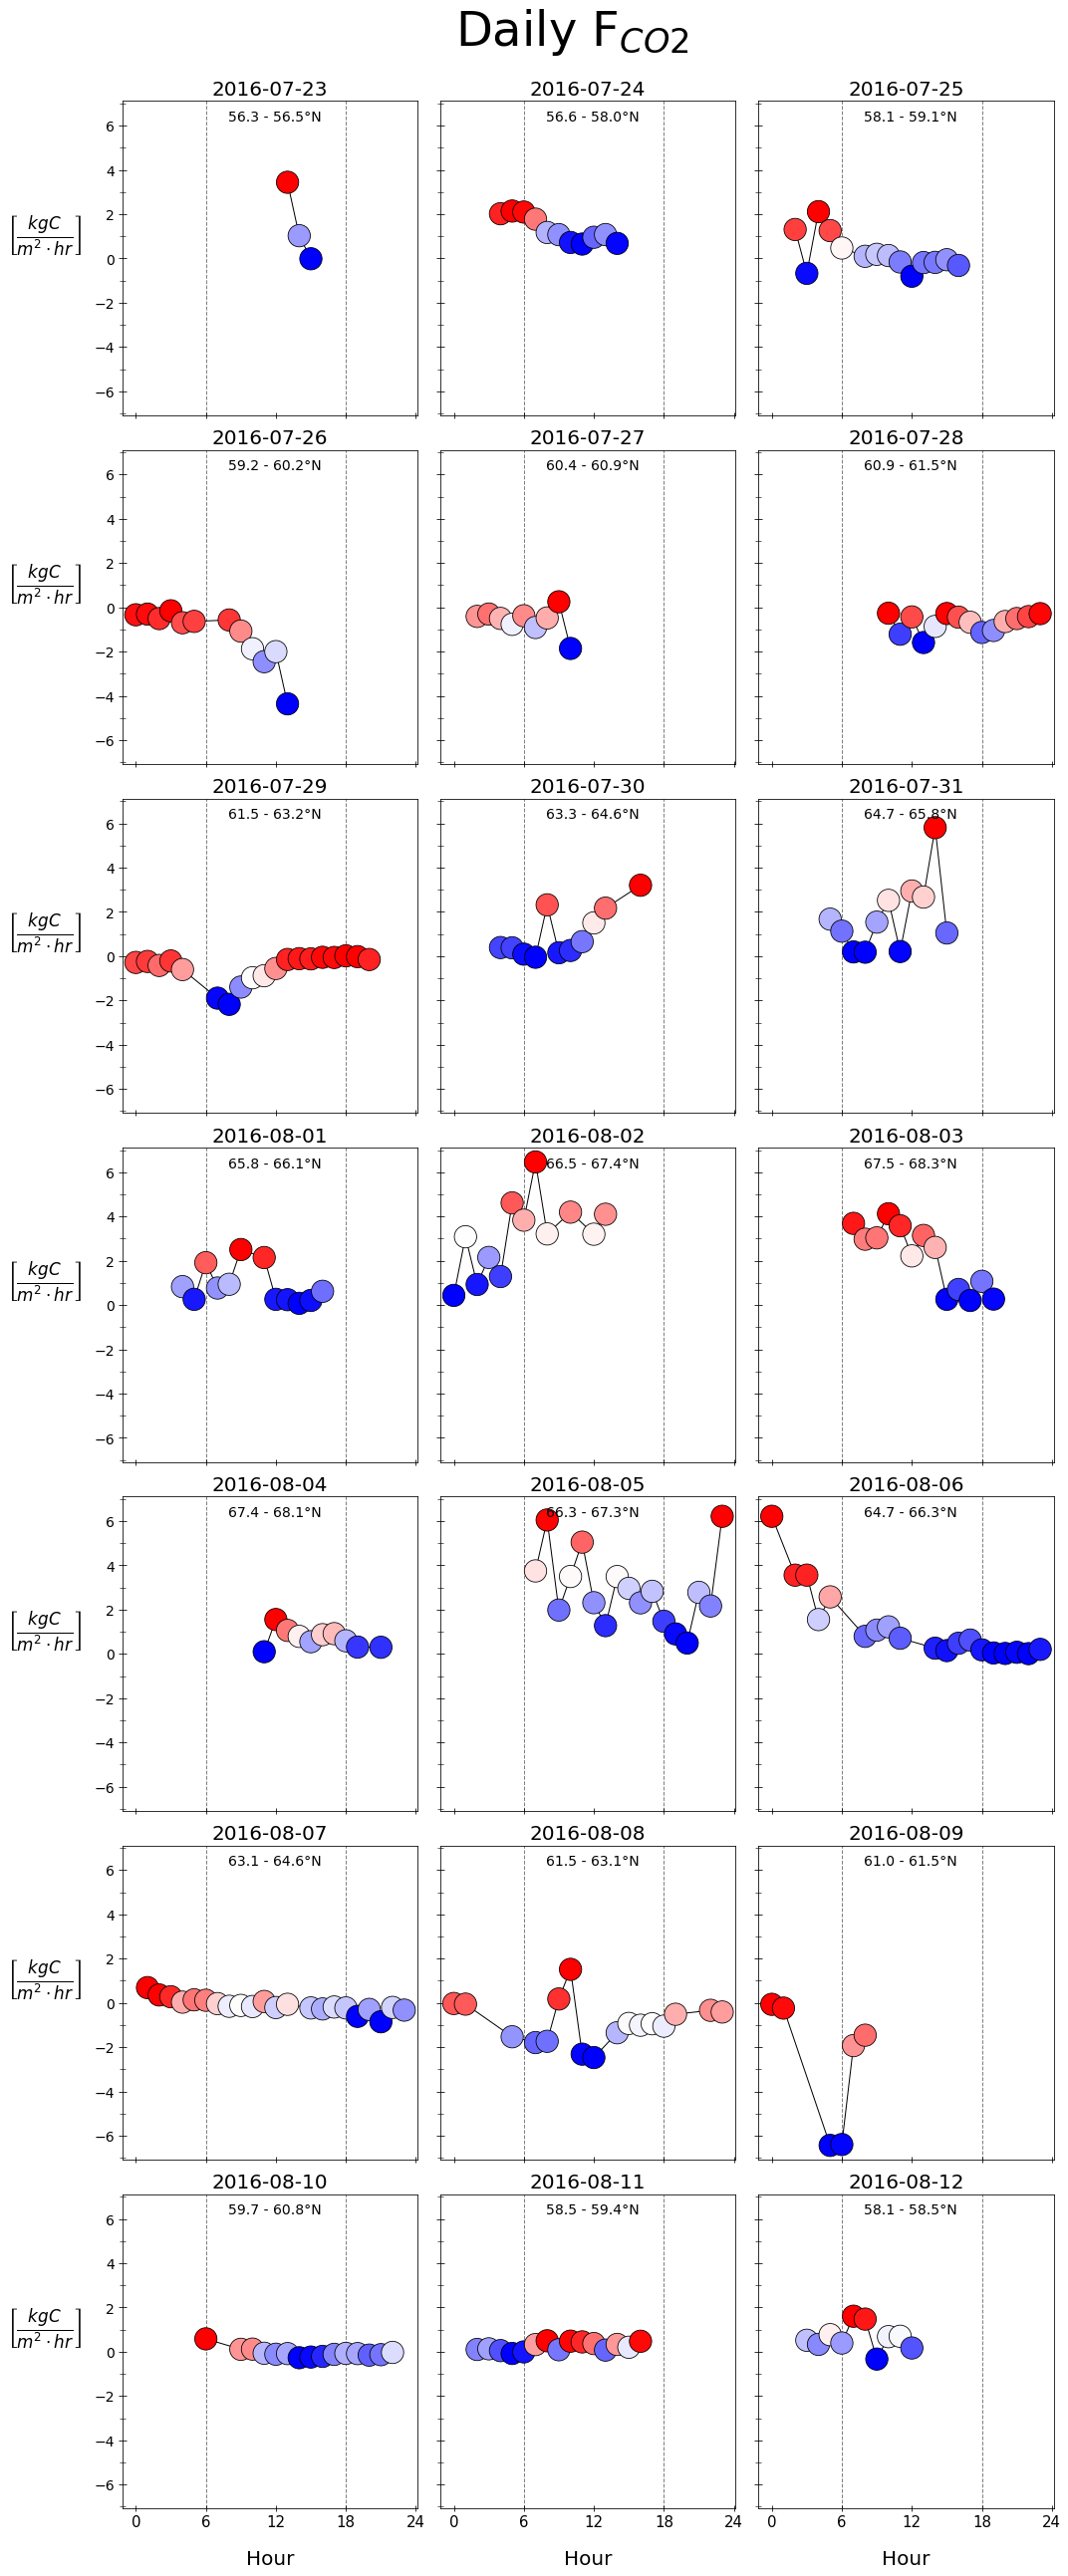

In [81]:
# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['Flux_C_kg_hr'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['Flux_C_kg_hr'], 
               cmap = 'bwr', c = group['Flux_C_kg_hr'],
               vmin = group['Flux_C_kg_hr'].quantile(0.05), 
               vmax = group['Flux_C_kg_hr'].quantile(0.95), 
               lw=0.8, s=500, edgecolor='black', zorder=2,)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', 
                      color='black', fontsize=24, labelpad=50, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    #ax.yaxis.set_major_locator(MaxNLocator(6)) 
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=14)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=14)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat' column in the current group
    lat_min, lat_max = group['lat'].min(), group['lat'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', 
            fontsize=14, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.suptitle('Daily F$_{CO2}$', fontsize=48, c='black', x=0.535, y=1.025)
plt.show()

#fig.savefig('Yenisei_2016_Cleaned_co2_Daily_hr_interpolated.png', dpi = 500, bbox_inches='tight')

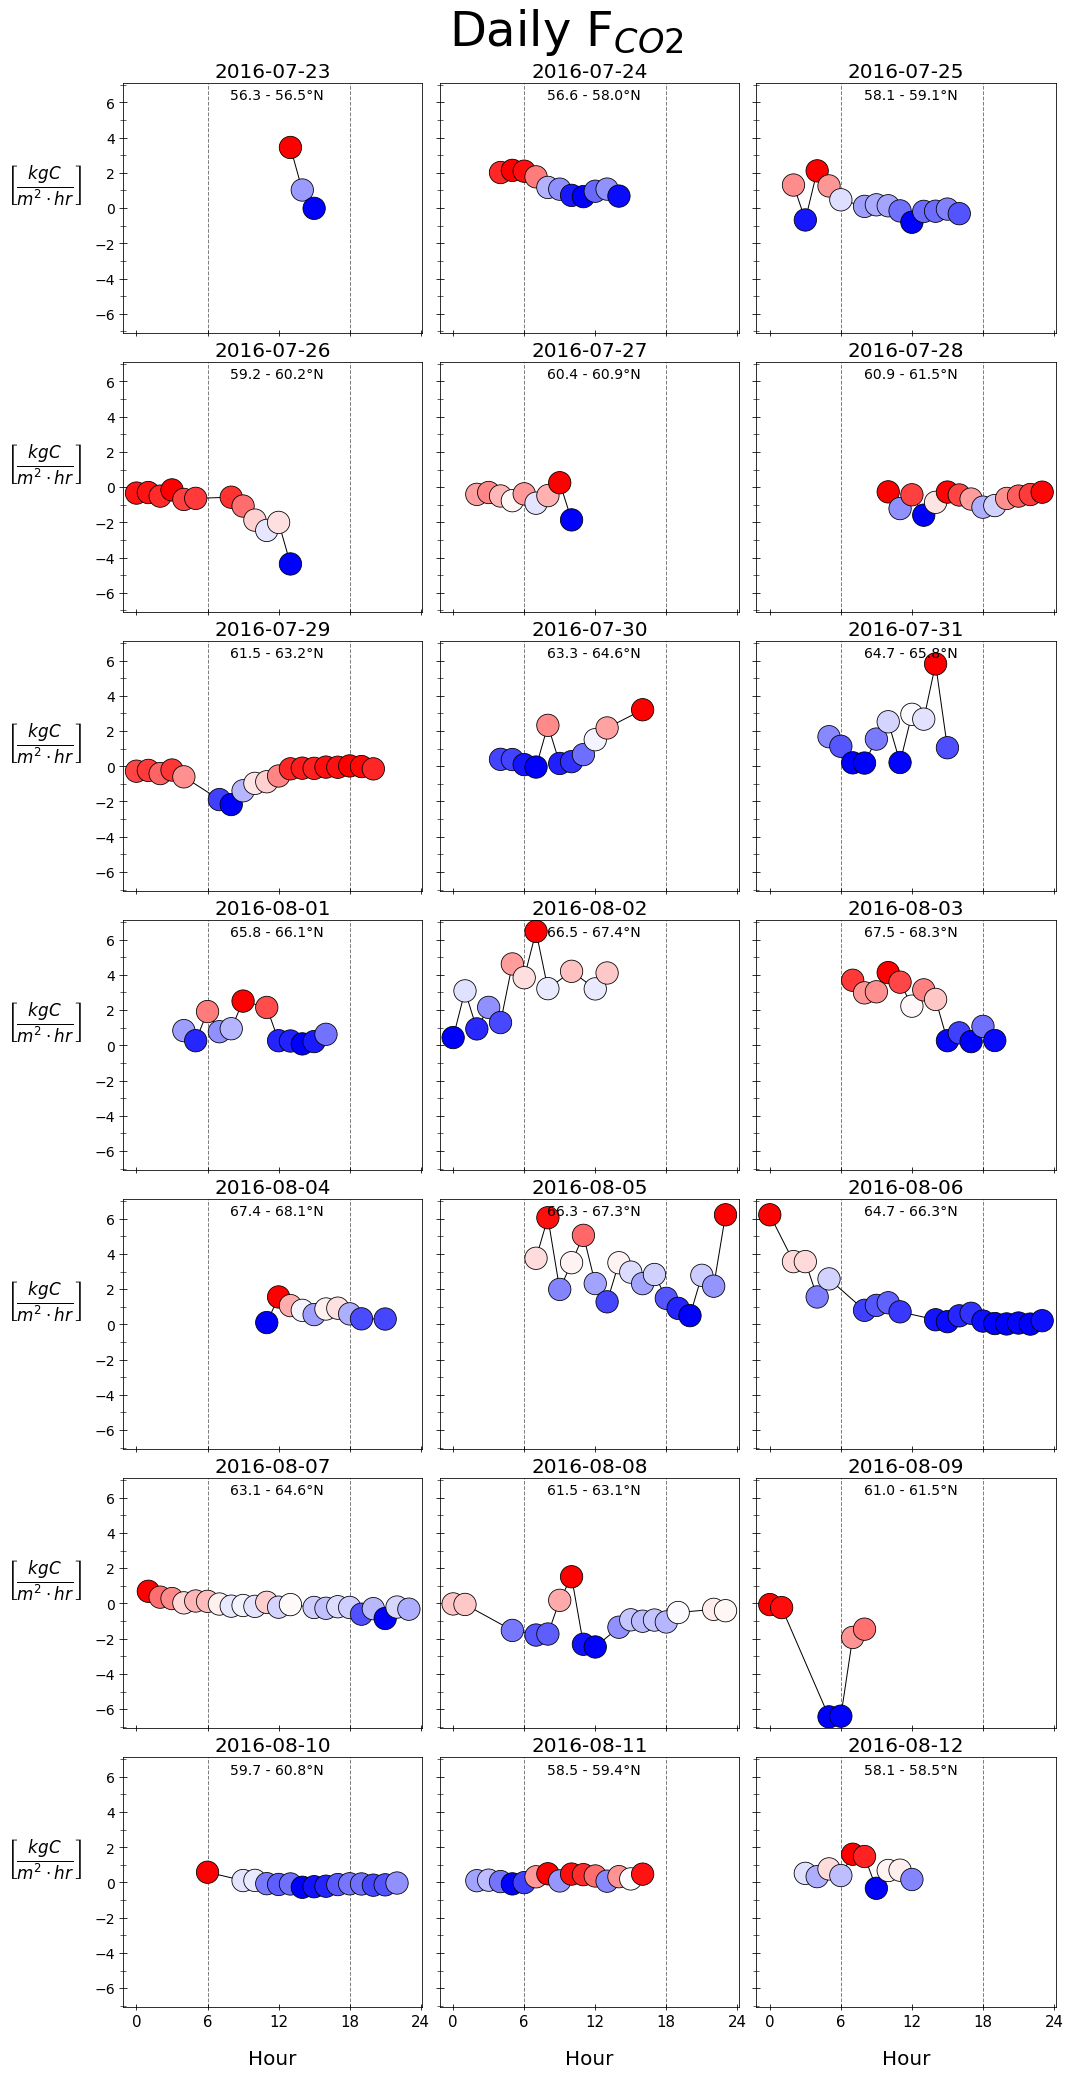

In [82]:
# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['Flux_C_kg_hr'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['Flux_C_kg_hr'], 
               cmap = 'bwr', c = group['Flux_C_kg_hr'], 
               lw=0.8, s=500, edgecolor='black', zorder=2,)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', 
                      color='black', fontsize=24, labelpad=50, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    #ax.yaxis.set_major_locator(MaxNLocator(6)) 
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=14)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=14)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat' column in the current group
    lat_min, lat_max = group['lat'].min(), group['lat'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', 
            fontsize=14, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout(pad=0.5)  # Adjust the spacing between subplots if needed
plt.suptitle('Daily F$_{CO2}$', fontsize=48, c='black', x=0.535, y=1.025)
plt.show()

#fig.savefig('Yenisei_2016_Daily_F_co2_1.png', dpi = 500, bbox_inches='tight')

In [83]:
print('WD: ', os.getcwd())

WD:  J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data


In [84]:
df_concat_1H_1 = df_concat_1H_1.sort_index()
df_concat_1H_2 = df_concat_1H_2.sort_index()

group_1a = df_concat_1H_1.groupby(df_concat_1H_1.index.date)
group_1b = df_concat_1H_2.groupby(df_concat_1H_2.index.date)

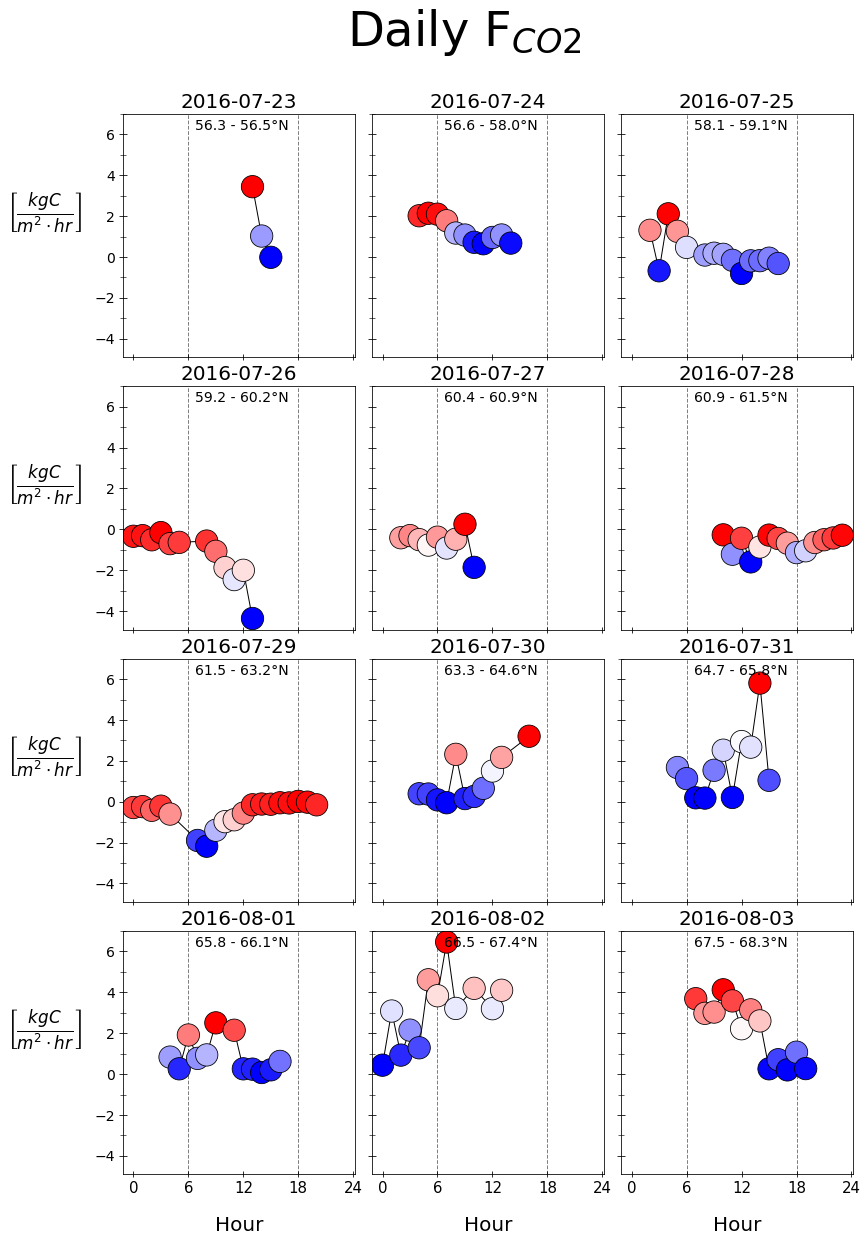

In [92]:
# Calculate the number of subplots needed
num_subplots = len(group_1a)
# Calculate the number of rows and columns for the subplot grid
num_rows = (-num_subplots) // -3  # Ceiling of the division
num_cols = 3  # Fixed the number of columns to 3

# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1a):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['Flux_C_kg_hr'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['Flux_C_kg_hr'], 
               cmap = 'bwr', c = group['Flux_C_kg_hr'], 
               lw=0.8, s=500, edgecolor='black', zorder=2,)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', 
                      color='black', fontsize=24, labelpad=50, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    #ax.yaxis.set_major_locator(MaxNLocator(6)) 
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=14)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=14)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat' column in the current group
    lat_min, lat_max = group['lat'].min(), group['lat'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', 
            fontsize=14, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout(pad=0.5)  # Adjust the spacing between subplots if needed
plt.suptitle('Daily F$_{CO2}$', fontsize=48, c='black', x=0.535, y=1.07)
plt.show()

fig.savefig('Yenisei_2016_Daily_F_co2_I.png', dpi = 500, bbox_inches='tight')

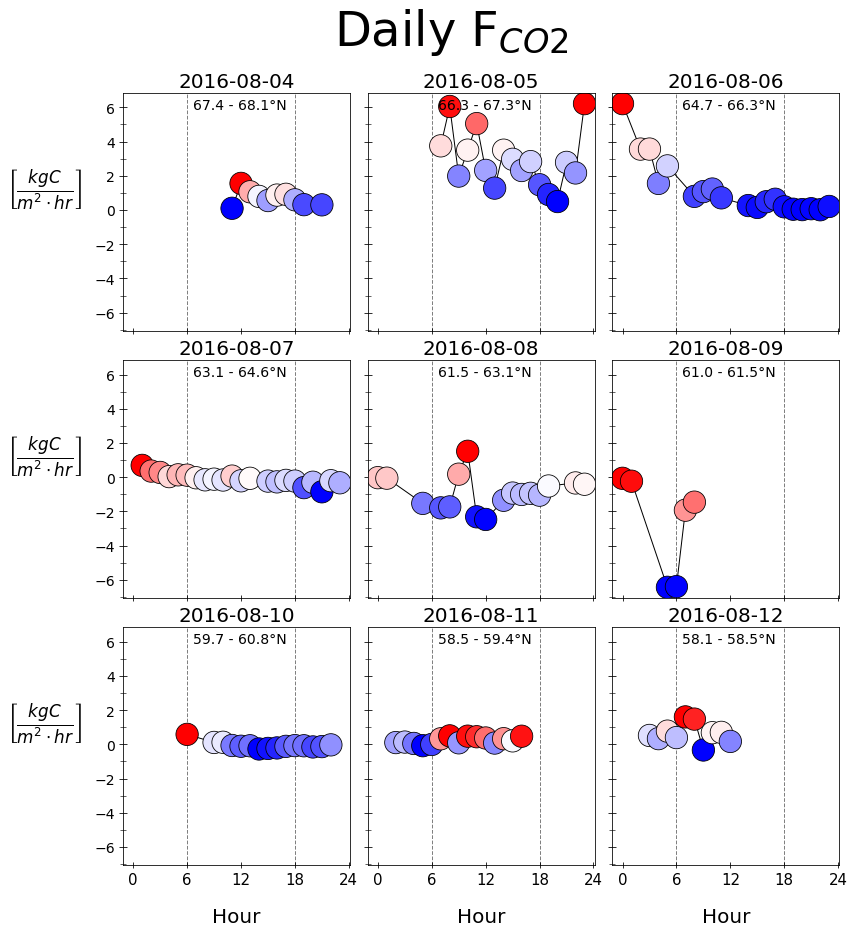

In [91]:
# Calculate the number of subplots needed
num_subplots = len(group_1b)
# Calculate the number of rows and columns for the subplot grid
num_rows = (-num_subplots) // -3
num_cols = 3

# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1b):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['Flux_C_kg_hr'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['Flux_C_kg_hr'], 
               cmap = 'bwr', c = group['Flux_C_kg_hr'], 
               lw=0.8, s=500, edgecolor='black', zorder=2,)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', 
                      color='black', fontsize=24, labelpad=50, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=14)
    #ax.yaxis.set_major_locator(MaxNLocator(6)) 
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=14)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=14)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat' column in the current group
    lat_min, lat_max = group['lat'].min(), group['lat'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', 
            fontsize=14, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout(pad=0.5)  # Adjust the spacing between subplots if needed
plt.suptitle('Daily F$_{CO2}$', fontsize=48, c='black', x=0.535, y=1.07)
plt.show()

fig.savefig('Yenisei_2016_Daily_F_co2_II.png', dpi = 500, bbox_inches='tight')

In [100]:
global_min = df_concat_1H_1['Flux_C_kg_hr'].min()
global_max = df_concat_1H_1['Flux_C_kg_hr'].max()
global_min

-4.360876351775664

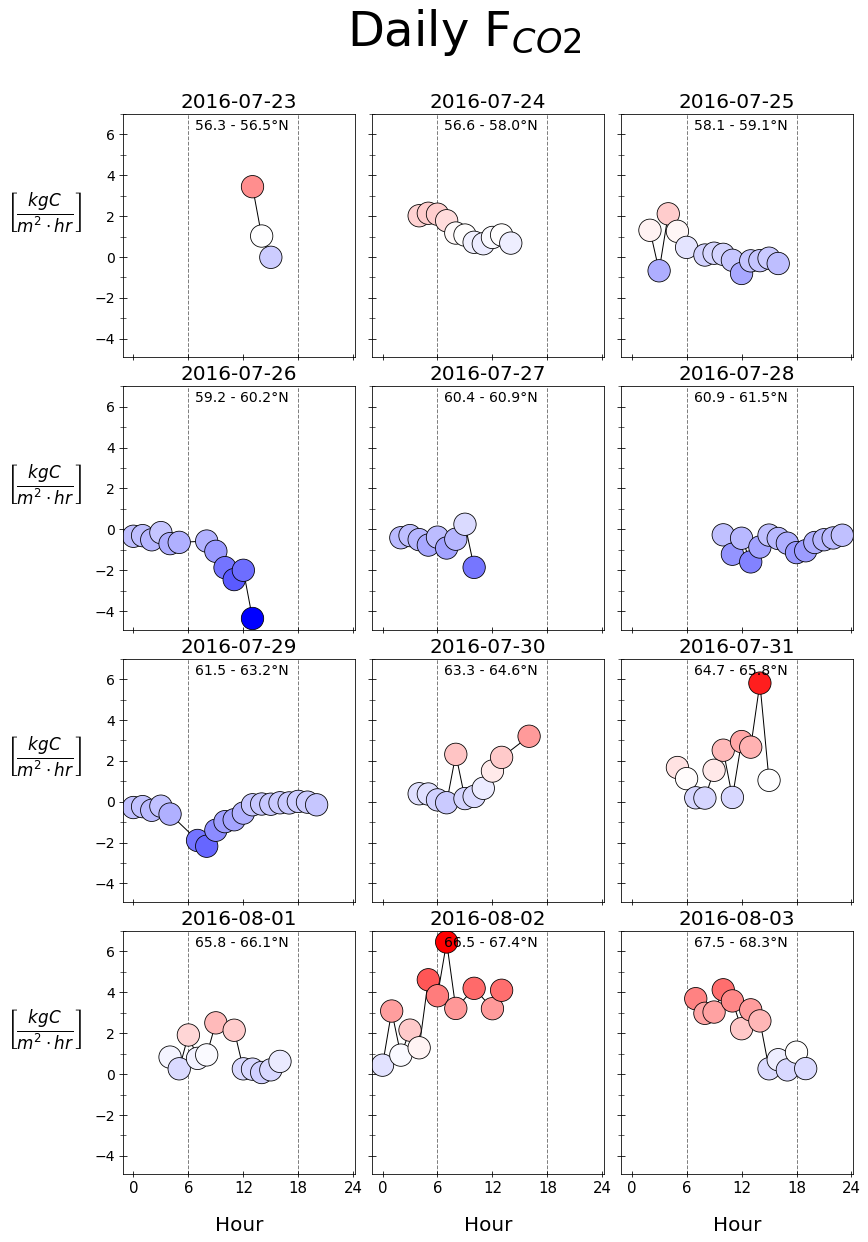

In [101]:
# Calculate the number of subplots needed
num_subplots = len(group_1a)
# Calculate the number of rows and columns for the subplot grid
num_rows = (-num_subplots) // -3  # Ceiling of the division
num_cols = 3  # Fixed the number of columns to 3

# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1a):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['Flux_C_kg_hr'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['Flux_C_kg_hr'], cmap='bwr', c=group['Flux_C_kg_hr'],
               vmin=global_min, 
               vmax=global_max, 
               lw=0.8, s=500, edgecolor='black', zorder=2)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', 
                      color='black', fontsize=24, labelpad=50, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    #ax.yaxis.set_major_locator(MaxNLocator(6)) 
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=14)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=14)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat' column in the current group
    lat_min, lat_max = group['lat'].min(), group['lat'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', 
            fontsize=14, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout(pad=0.5)  # Adjust the spacing between subplots if needed
plt.suptitle('Daily F$_{CO2}$', fontsize=48, c='black', x=0.535, y=1.07)
plt.show()

fig.savefig('Yenisei_2016_Daily_F_co2_Ia.png', dpi = 500, bbox_inches='tight')

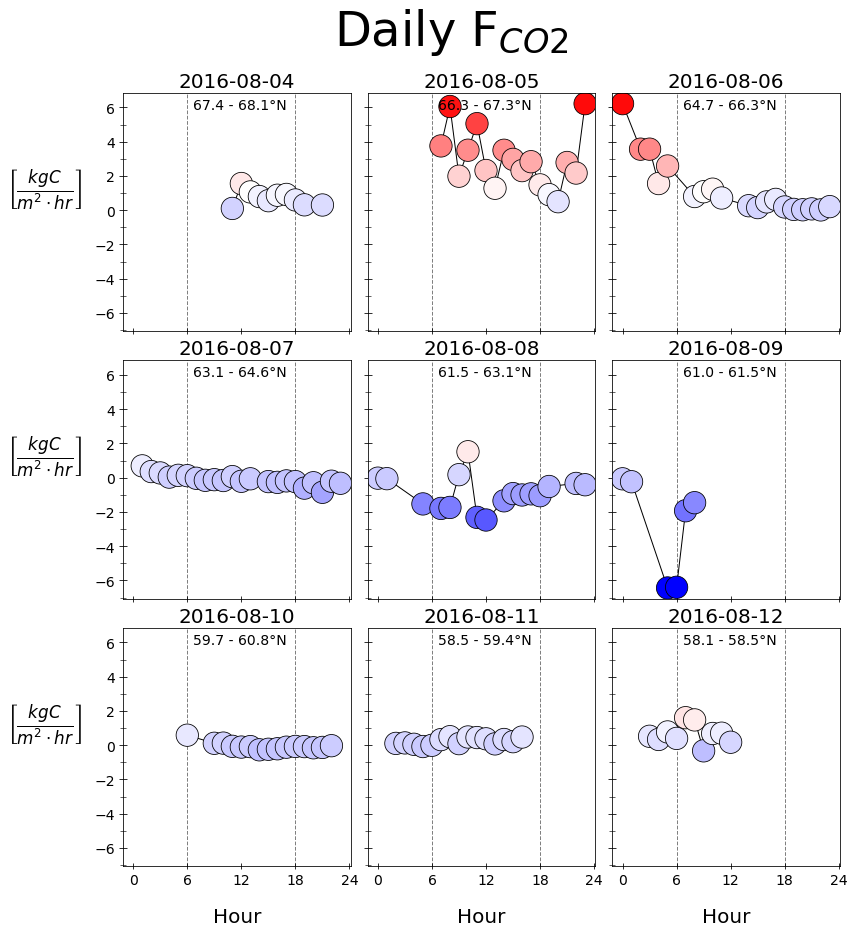

In [103]:
# Calculate the number of subplots needed
num_subplots = len(group_1b)
# Calculate the number of rows and columns for the subplot grid
num_rows = (-num_subplots) // -3  # Ceiling of the division
num_cols = 3  # Fixed the number of columns to 3

# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1b):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['Flux_C_kg_hr'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['Flux_C_kg_hr'], cmap='bwr', c=group['Flux_C_kg_hr'],
               vmin=global_min, 
               vmax=global_max, 
               lw=0.8, s=500, edgecolor='black', zorder=2)
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', 
                      color='black', fontsize=24, labelpad=50, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=14)
    #ax.yaxis.set_major_locator(MaxNLocator(6)) 
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=14)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=14)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat' column in the current group
    lat_min, lat_max = group['lat'].min(), group['lat'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', 
            fontsize=14, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout(pad=0.5)  # Adjust the spacing between subplots if needed
plt.suptitle('Daily F$_{CO2}$', fontsize=48, c='black', x=0.535, y=1.07)
plt.show()

fig.savefig('Yenisei_2016_Daily_F_co2_IIb.png', dpi = 500, bbox_inches='tight')

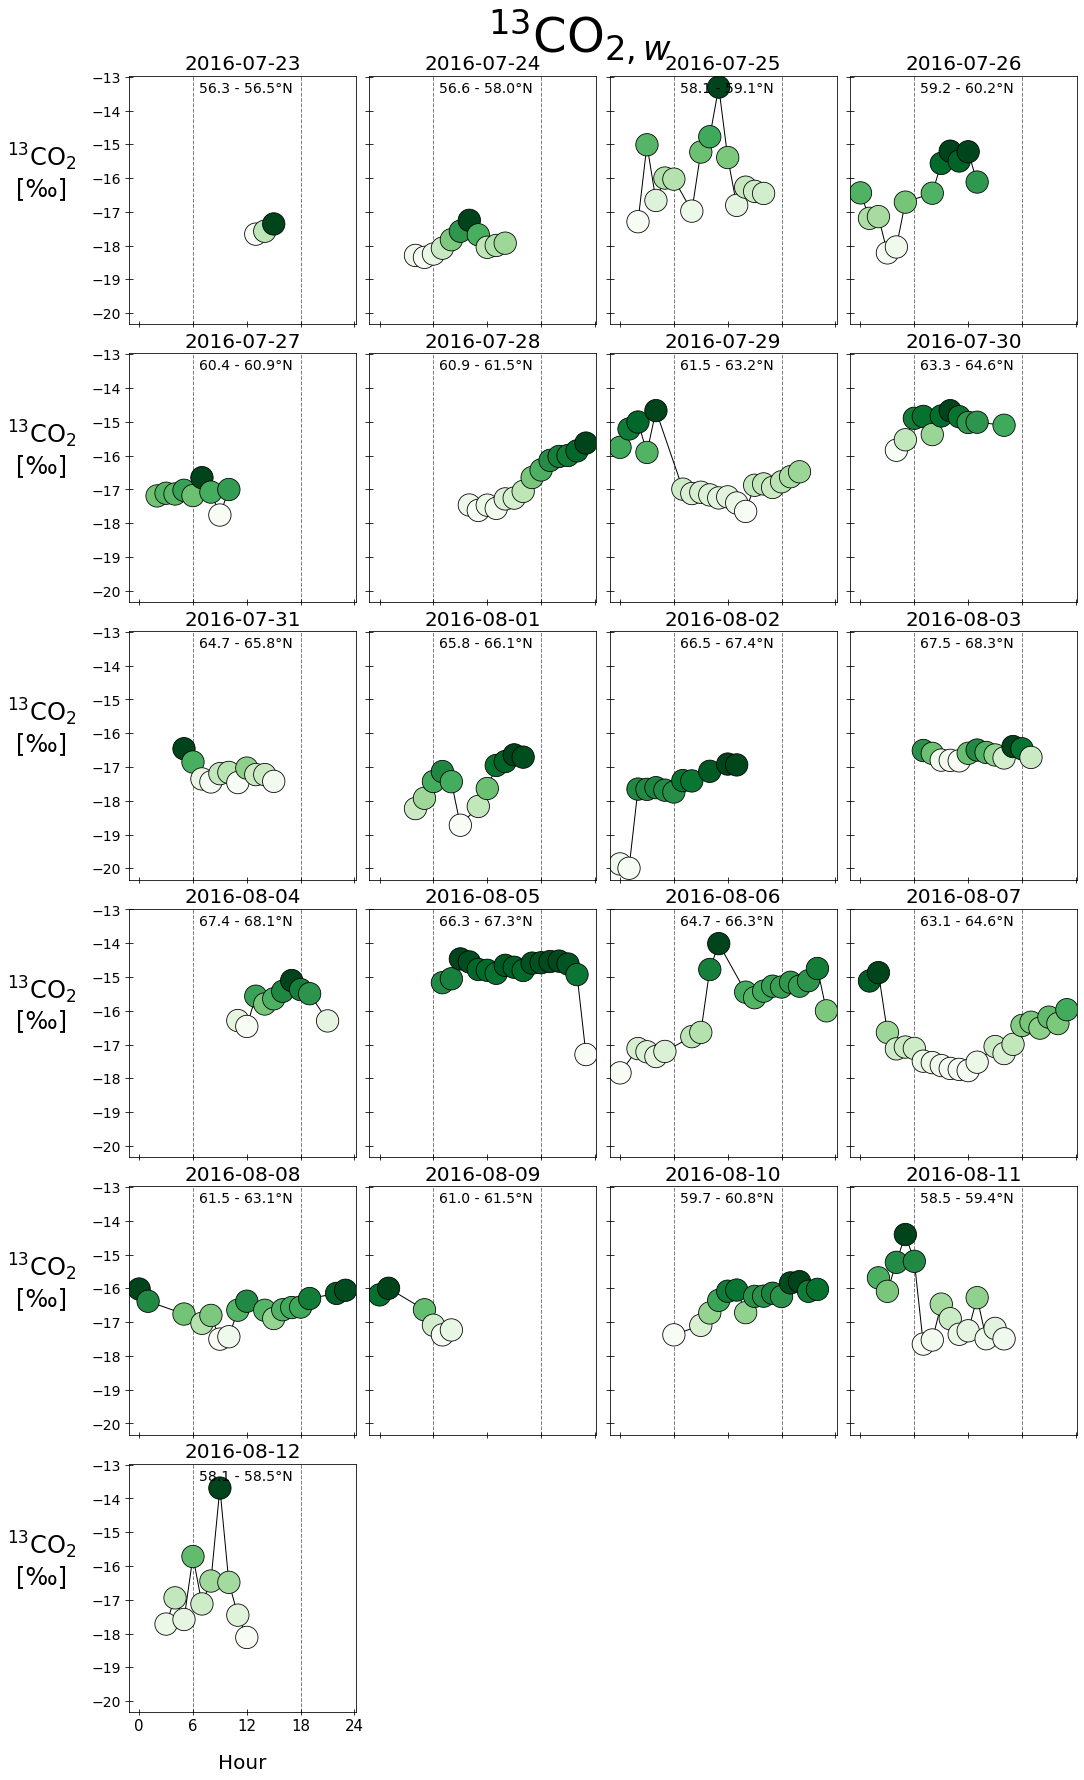

In [55]:
# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    
    ax.plot(group['hour'], group['ico2_w'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['ico2_w'], 
               cmap = 'Greens', c = group['ico2_w'], 
               lw=0.8, s=500, edgecolor='black', zorder=2,)
    
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('$^{13}$CO$_{2}$\n[‰]', 
                      color='black', fontsize=24, labelpad=50, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    #ax.yaxis.set_major_locator(MaxNLocator(6)) 
    #ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=14)
    #ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=14)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat' column in the current group
    lat_min, lat_max = group['lat'].min(), group['lat'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', 
            fontsize=14, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout(pad=0.5)  # Adjust the spacing between subplots if needed
plt.suptitle('$^{13}$CO$_{2,w}$', fontsize=48, c='black', x=0.535, y=1.025)
plt.show()

fig.savefig('Yenisei_2016_Daily_concat_1H_ico2w.png', dpi = 500, bbox_inches='tight')

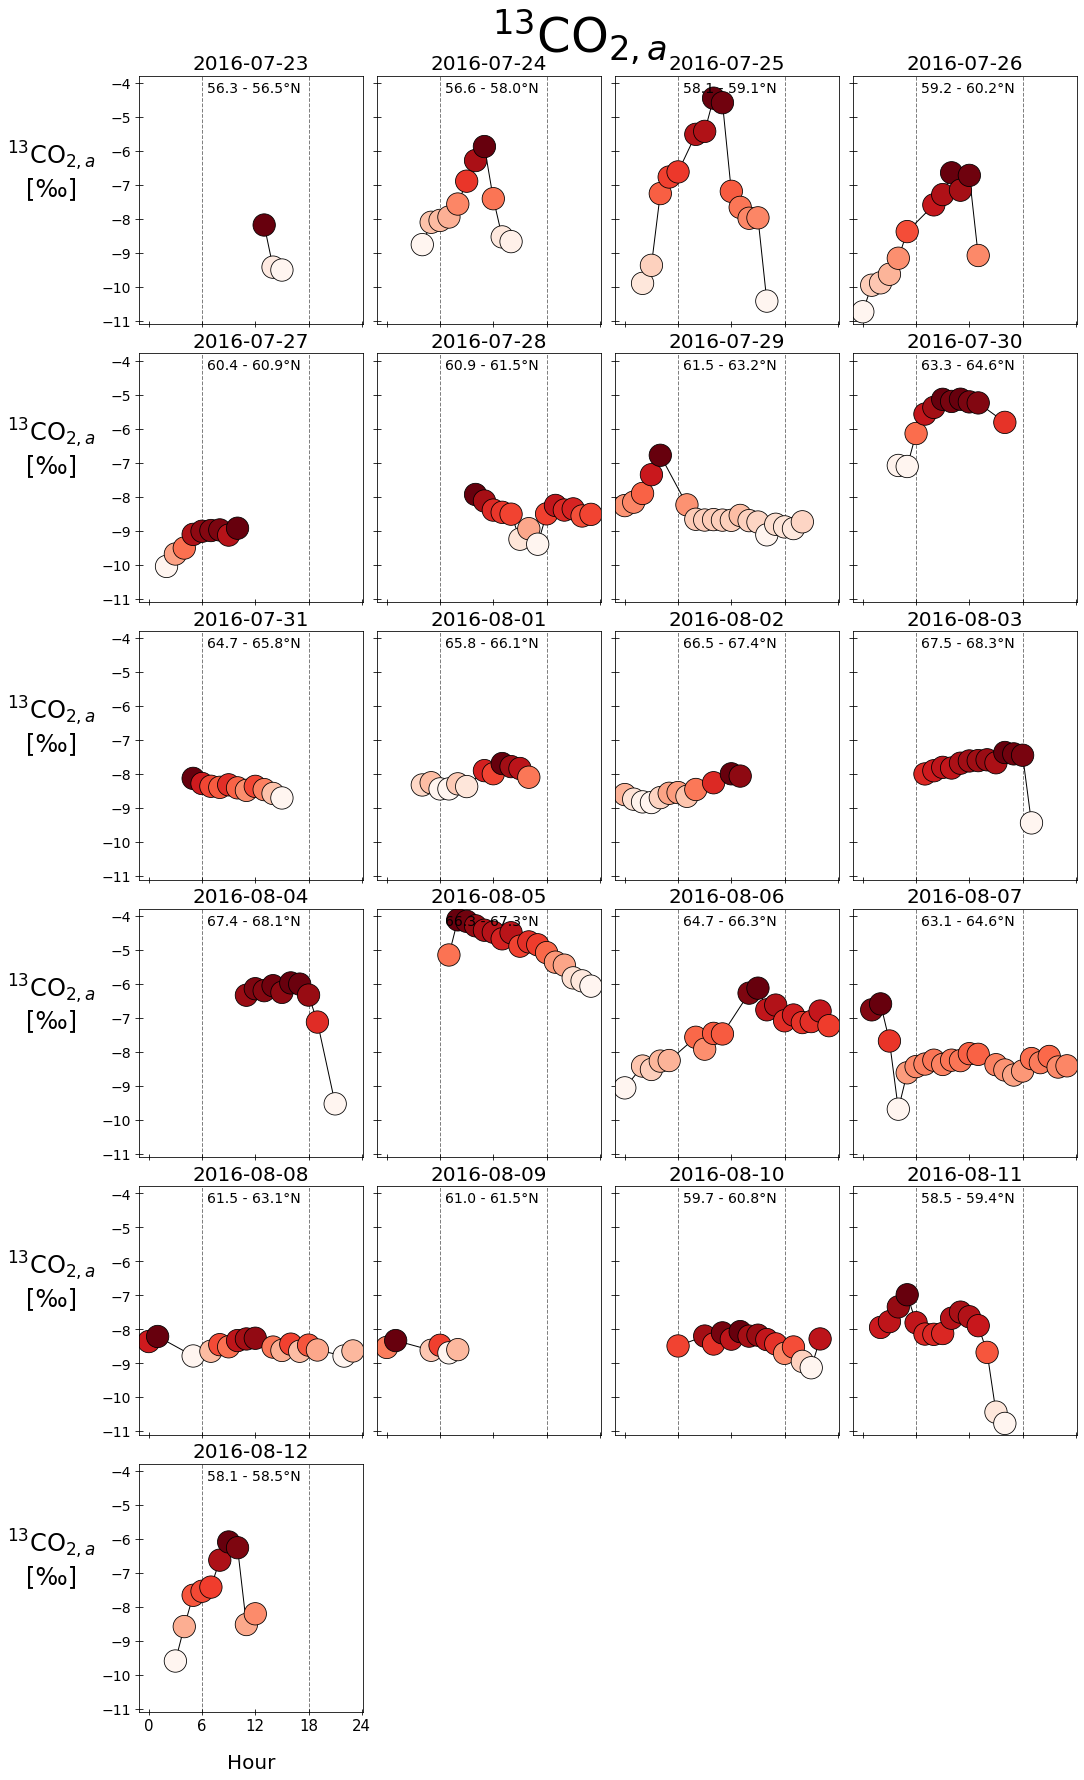

In [54]:
# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1):
    ax = axs[i] if num_subplots > 1 else axs  # Access the appropriate subplot
    
    ax.plot(group['hour'], group['ico2_a'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['ico2_a'], 
               cmap = 'Reds', c = group['ico2_a'], 
               lw=0.8, s=500, edgecolor='black', zorder=2,)
    
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols == 0:
        ax.set_ylabel('$^{13}$CO$_{2,a}$\n[‰]', 
                      color='black', fontsize=24, labelpad=50, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols * (num_rows - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    #ax.yaxis.set_major_locator(MaxNLocator(6)) 
    #ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=14)
    #ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=14)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat' column in the current group
    lat_min, lat_max = group['lat'].min(), group['lat'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', 
            fontsize=14, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots < len(axs):
    for j in range(num_subplots, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout(pad=0.5)  # Adjust the spacing between subplots if needed
plt.suptitle('$^{13}$CO$_{2,a}$', fontsize=48, c='black', x=0.535, y=1.025)
plt.show()

fig.savefig('Yenisei_2016_Daily_concat_1H_ico2a.png', dpi = 500, bbox_inches='tight')

<br><br><br><br><br><br><br><br>

# 4 Hour

<br><br><br><br><br><br><br><br>

In [20]:
# 4H Groupby of the Concatenated 1H Dataframe
df = df_concat_1H.groupby(pd.Grouper(freq='4H', sort=True)).mean()
df_std = df_concat_1H.groupby(pd.Grouper(freq='4H', sort=True)).std()
df_max = df_concat_1H.groupby(pd.Grouper(freq='4H', sort=True)).max()
df_min = df_concat_1H.groupby(pd.Grouper(freq='4H', sort=True)).min()

# Add Statistical Stuff
df['co2_w_std'] = df_std['co2_w']
df['co2_w_max'] = df_max['co2_w']
df['co2_w_min'] = df_min['co2_w']

df['ico2_w_std'] = df_std['ico2_w']
df['ico2_w_max'] = df_max['ico2_w']
df['ico2_w_min'] = df_min['ico2_w']

df['co2_a_std'] = df_std['co2_a']
df['co2_a_max'] = df_max['co2_a']
df['co2_a_min'] = df_min['co2_a']

df['ico2_a_std'] = df_std['ico2_a']
df['ico2_a_max'] = df_max['ico2_a']
df['ico2_a_min'] = df_min['ico2_a']

df['ch4_w_std'] = df_std['ch4_w']
df['ch4_w_max'] = df_max['ch4_w']
df['ch4_w_min'] = df_min['ch4_w']

df['ich4_w_std'] = df_std['ich4_w']
df['ich4_w_max'] = df_max['ich4_w']
df['ich4_w_min'] = df_min['ich4_w']

df['ch4_a_std'] = df_std['ch4_a']
df['ch4_a_max'] = df_max['ch4_a']
df['ch4_a_min'] = df_min['ch4_a']

df['ich4_a_std'] = df_std['ich4_a']
df['ich4_a_max'] = df_max['ich4_a']
df['ich4_a_min'] = df_min['ich4_a']

df['Flux_C_kg_hr_std'] = df_std['Flux_C_kg_hr']
df['Flux_C_kg_hr_max'] = df_max['Flux_C_kg_hr']
df['Flux_C_kg_hr_min'] = df_min['Flux_C_kg_hr']

# Transect I
df_concat_4H_1 = df.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 
df_concat_4H_2 = df.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']

# Sort
df_concat_4H_1 = df_concat_4H_1.sort_values(by='lat', ascending=True)
df_concat_4H_2 = df_concat_4H_2.sort_values(by='lat', ascending=True)

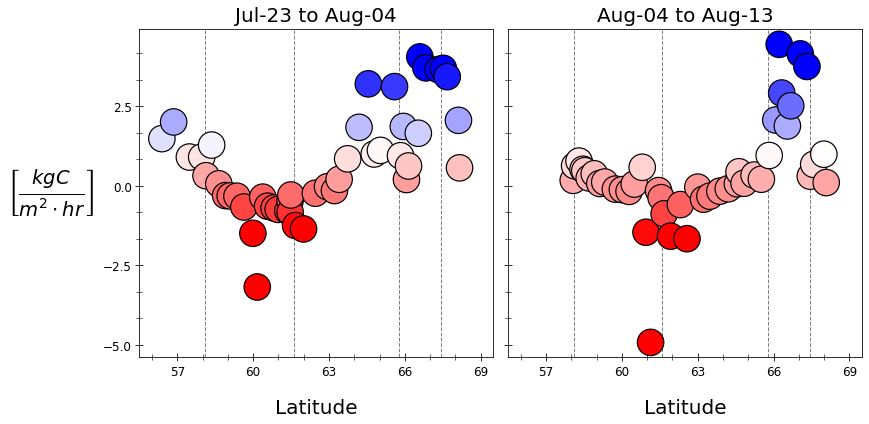

In [21]:
# Water
def flux_co2(x1, y1, data1, data2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    
    ax[0].set_title('Jul-23 to Aug-04', fontsize=20, c='black', pad=8)
    ax[1].set_title('Aug-04 to Aug-13', fontsize=20, c='black', pad=8)
    ax[0].set_ylabel(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', color='black', 
                     fontsize=28, rotation=0) # labelpad=50, 
    ax[0].get_yaxis().set_label_coords(-0.25, 0.425)
    ax[0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
    ax[1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
    
    ax[0].scatter(data1[x1], data1[y1], cmap='bwr_r', lw=1.2, edgecolor='black', s=700, zorder=1, 
                  c=data1[y1],  vmin=data1[y1].quantile(0.05), vmax=data1[y1].quantile(0.95))
    
    ax[1].scatter(data2[x1], data2[y1], cmap='bwr_r', lw=1.2, edgecolor='black', s=700, zorder=1, 
                  c=data2[y1], vmin=data2[y1].quantile(0.05), vmax=data2[y1].quantile(0.95))   
    
    for ax in ax:
        ax.set_xlim(55.5, 69.5)
        #ax.set_ylim(-150, 350)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))              
        ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
        ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
        ax.yaxis.set_major_locator(MaxNLocator(5)) 
        ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(3))
        ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
        ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
        ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
        ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
        ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
        ax.axvline(67.44, color='grey', ls='--', lw=1, zorder=0)  # Igarka
        #ax.set_ylim(-7.5,7.5)
        #ax.axvspan(61, 62, alpha=0.15, color='black')

    #fig.suptitle('J$_{CO2}$', fontsize=40, x=0.535, y=0.92)
    fig.tight_layout()
        
    return fig, ax

fig, ax = flux_co2('lat', 'Flux_C_kg_hr', df_concat_4H_1, df_concat_4H_2)

#fig.savefig('Flux_CO2_cruisies_4H.png', dpi = 500, bbox_inches='tight')

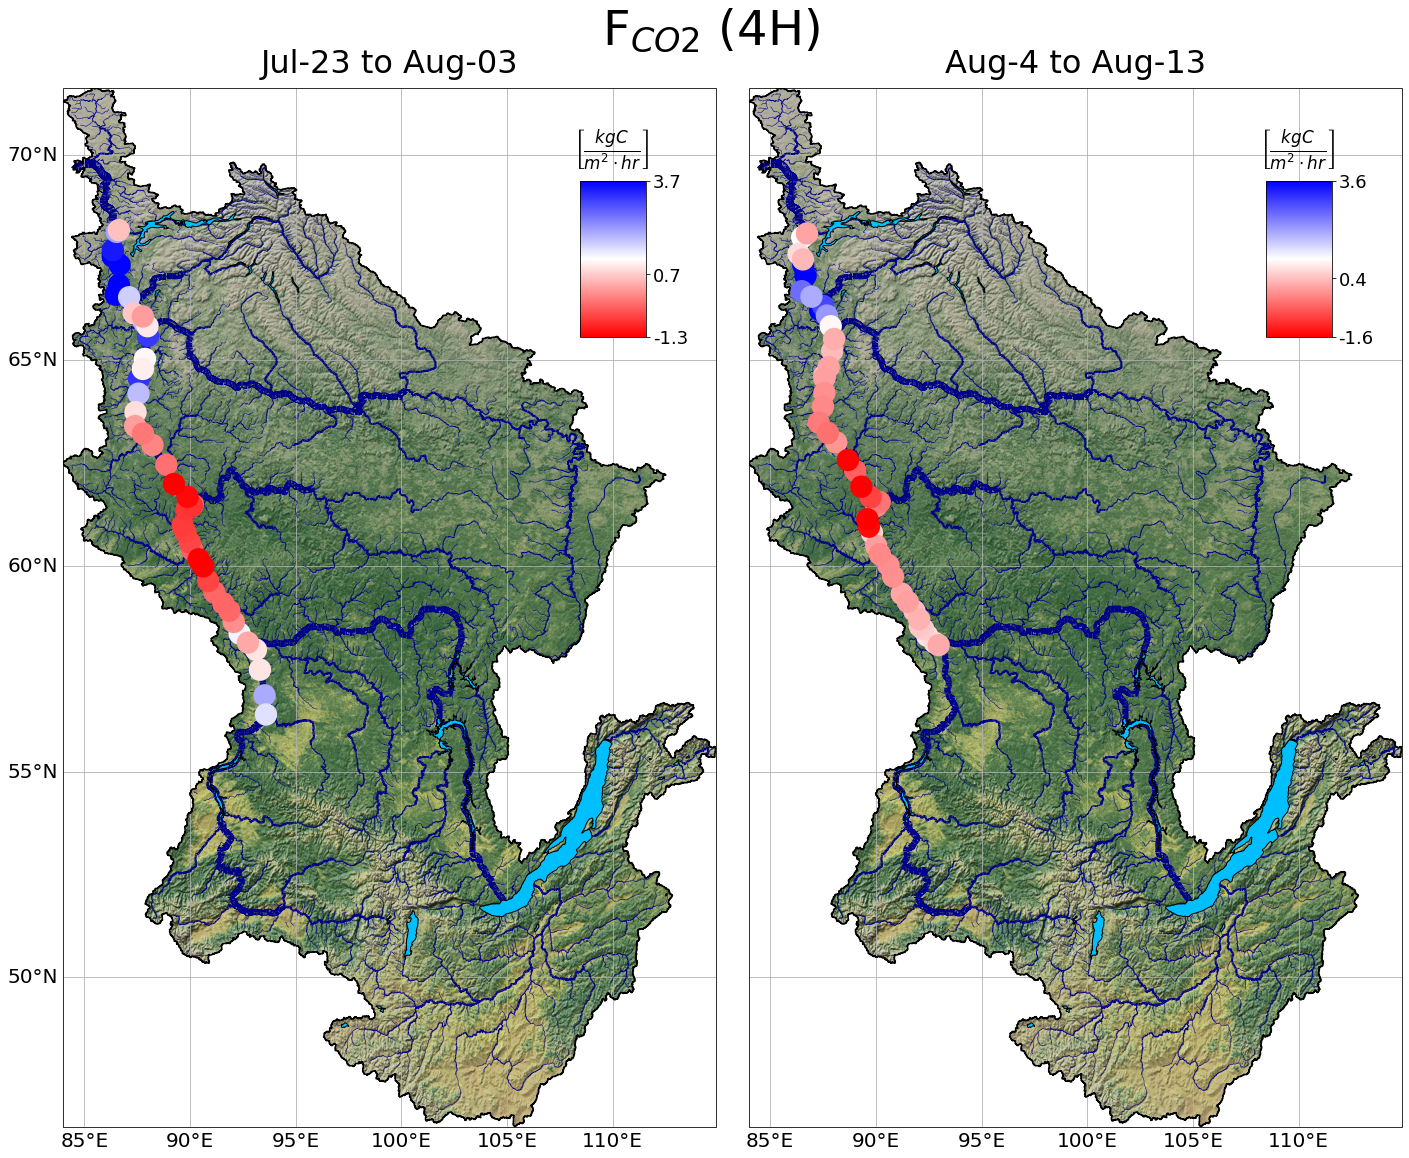

In [26]:
# Sort
df_concat_4H_1 = df_concat_4H_1.sort_values(by='Flux_C_kg_hr', ascending=True)
df_concat_4H_2 = df_concat_4H_2.sort_values(by='Flux_C_kg_hr', ascending=True)

# Plot Structure
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(24,24), subplot_kw={"projection": ccrs.PlateCarree()})

# Titles
ax[0].set_title('Jul-23 to Aug-03', fontsize=32, c='black', pad=15)
ax[1].set_title('Aug-4 to Aug-13', fontsize=32, c='black', pad=15)
# Scatters
m1 = ax[0].scatter(df_concat_4H_1['lon'], df_concat_4H_1['lat'], c=df_concat_4H_1['Flux_C_kg_hr'], cmap='bwr_r', transform = ccrs.PlateCarree(), 
                   vmin=df_concat_4H_1['Flux_C_kg_hr'].quantile(0.05), vmax=df_concat_4H_1['Flux_C_kg_hr'].quantile(0.95), marker='o', s=500, linewidth=1, edgecolor='none', zorder=9)
m2 = ax[1].scatter(df_concat_4H_2['lon'], df_concat_4H_2['lat'], c=df_concat_4H_2['Flux_C_kg_hr'], cmap='bwr_r', transform = ccrs.PlateCarree(), 
                   vmin=df_concat_4H_2['Flux_C_kg_hr'].quantile(0.05), vmax=df_concat_4H_2['Flux_C_kg_hr'].quantile(0.95), marker='o', s=500, linewidth=1, edgecolor='none', zorder=9)
# Grids
gl1 = ax[0].gridlines(draw_labels=True, linewidth=0.8, x_inline=False, y_inline=False, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)
gl1.xlabel_style, gl1.ylabel_style, gl1.top_labels, gl1.right_labels = {'size': 20, 'color': 'black'}, {'size': 20, 'color': 'black'}, False, False
gl2 = ax[1].gridlines(draw_labels=True, linewidth=0.8, x_inline=False, y_inline=False, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)
gl2.xlabel_style, gl2.ylabel_style, gl2.top_labels, gl2.right_labels = {'size': 20, 'color': 'black'}, {'size': 0, 'color': 'white'}, False, False

# Colorbar 1
cb_ax1 = inset_axes(ax[0], width="10%", height="15%", loc='upper right', bbox_to_anchor=(-0.100, -0.085, 1, 1), bbox_transform=ax[0].transAxes)
cb1 = plt.colorbar(m1, cax=cb_ax1)
cb1.set_label(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', fontsize=18, labelpad=100)
cb1.ax.tick_params(labelsize=18)
cb1.set_ticks([df_concat_4H_1['Flux_C_kg_hr'].quantile(0.05), df_concat_4H_1['Flux_C_kg_hr'].mean(), df_concat_4H_1['Flux_C_kg_hr'].quantile(0.95)])
cb1.set_ticklabels(['{:.1f}'.format(df_concat_4H_1['Flux_C_kg_hr'].quantile(0.05)), '{:.1f}'.format(df_concat_4H_1['Flux_C_kg_hr'].mean()), '{:.1f}'.format(df_concat_4H_1['Flux_C_kg_hr'].quantile(0.95))])
cb1.ax.yaxis.set_label_coords(-0.1, 1.2)  # Adjust the x and y coordinates as needed
cb1.ax.set_ylabel(cb1.ax.get_ylabel(), rotation=0, fontsize=24, ha='left', va='center')

# Colorbar 2
cb_ax2 = inset_axes(ax[1], width="10%", height="15%", loc='upper right', bbox_to_anchor=(-0.100, -0.085, 1, 1), bbox_transform=ax[1].transAxes)
cb2 = plt.colorbar(m2, cax=cb_ax2)
cb2.set_label(r'$\left[ \frac{kgC}{m^{2} \cdot hr} \right]$', fontsize=18, labelpad=80)
cb2.ax.tick_params(labelsize=18)
cb2.set_ticks([df_concat_4H_2['Flux_C_kg_hr'].quantile(0.05), df_concat_4H_2['Flux_C_kg_hr'].mean(), df_concat_4H_2['Flux_C_kg_hr'].quantile(0.95)])
cb2.set_ticklabels(['{:.1f}'.format(df_concat_4H_2['Flux_C_kg_hr'].quantile(0.05)), '{:.1f}'.format(df_concat_4H_2['Flux_C_kg_hr'].mean()), '{:.1f}'.format(df_concat_4H_2['Flux_C_kg_hr'].quantile(0.95))])
cb2.ax.yaxis.set_label_coords(-0.1, 1.2)  # Adjust the x and y coordinates as needed
cb2.ax.set_ylabel(cb2.ax.get_ylabel(), rotation=0, fontsize=24, ha='left', va='center')

# Loops
for ax in ax:
    xmin, ymin, xmax, ymax = nat_earth.bounds # Get the extent of the raster image
    ax.imshow(Yenisei_NE1_HR_LC_SR, origin='upper', extent=[xmin, xmax, ymin, ymax], transform=ccrs.PlateCarree())
    AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
    gpd_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', lw=1, zorder=6)
    HydroRIVERS_flow_2.plot(ax=ax, color='darkblue', lw=8, zorder=1)
    HydroRIVERS_flow_3.plot(ax=ax, color='darkblue', lw=6, zorder=2)
    HydroRIVERS_flow_4.plot(ax=ax, color='darkblue', lw=2, zorder=3)
    HydroRIVERS_flow_5.plot(ax=ax, color='darkblue', lw=1, zorder=4) # < 10$^2$ [m$^3$/s]
    HydroRIVERS_flow_6.plot(ax=ax, color='darkblue', lw=0.5, zorder=4) # label='10$^0$ - 10$^1$ [m$^3$/s]'
    #ax.legend(ncol=1, prop={'size': 18}) # prop={'size': 24}
        
#fig.tight_layout()

# Add a main title (suptitle)
plt.suptitle('F$_{CO2}$ (4H)', fontsize=48, x=0.50, y=0.85)

# Adjust padding between subplots manually
plt.subplots_adjust(wspace=0.05)

fig.savefig('Yenisei_2016_FLUX_4H.png', dpi = 500, bbox_inches='tight')